In [220]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import gc
import tensorflow as tf

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
import shutil
print(os.listdir("../input"))

['.dist', 'base_dir', 'Notebook_A.ipynb', 'Notebook_B.ipynb', 'Notebook_C_test_path.ipynb', 'sample_submission.csv', 'submission.csv', 'test', 'train', 'train_labels.csv']


In [221]:
print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]
[]


In [222]:
from tensorflow.python.client import device_lib

Configuring Torch

In [248]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
print(torch.version.cuda)
torch.cuda.is_available()
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]



11.7


Over the last few decades Machine learning has proven to be incredibly useful for medical imaging analysis due to its ability to handle large amounts of data, identify patterns, and assist medical professionals in making more accurate diagnoses and treatment decisions.
A Machine learning model will not tire like a person will and can reduce human error, increase the rates of early detections of diseases and do so in an accurate and precise way that even the most skilled person may struggle with.
To help further the process along (albeit for free), a competition was held to determine if an algorithm could be developed to identify metastatic cancer in image patches as small as 1 pixel.


About the dataset:


The dataset itself consists of two sets of images. One set consisting of over 200,000 images, each labeled with a 1 or a 0, depending upon the diagnosis. The other set is about 57,000 unlabelled images. Which will be used to test the accuracy of the model that will be constructed during the course of this project. There is also a file for the labels of the data set. The accuracy of the model will be gauged by submitting the results to the Kaggle platform for scoring.


# Setting up pathing 

Procedure: Data Loading
The datasets were first loaded in using the standard read_csv function. The contents are the identifications and labels for each training data set.


In [249]:
path = "../input/" 
train_path = path + 'train/'
test_path = path + 'test/'

To streamline the process a base directory was created for training sample data and test sample data. 

In [250]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 

In [251]:
df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0]) 

In [252]:
df

,path,id
0,../input/train\00001b2b5609af42ab0ab276dd4cd41...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5
1,../input/train\000020de2aa6193f4c160e398a8edea...,000020de2aa6193f4c160e398a8edea95b1da598
2,../input/train\00004aab08381d25d315384d646f5ce...,00004aab08381d25d315384d646f5ce413ea24b1
3,../input/train\0000d563d5cfafc4e68acb7c9829258...,0000d563d5cfafc4e68acb7c9829258a298d9b6a
4,../input/train\0000da768d06b879e5754c43e2298ce...,0000da768d06b879e5754c43e2298ce48726f722
...,...,...
220020,../input/train\fffe6c73afcf5f5da5818fb70cb7230...,fffe6c73afcf5f5da5818fb70cb723026b172eca
220021,../input/train\fffeb3f5361ea57e728fb689e6be34d...,fffeb3f5361ea57e728fb689e6be34d07d16ca7e
220022,../input/train\fffeca85b16452a7709d163e05a70e6...,fffeca85b16452a7709d163e05a70e646782b3cc
220023,../input/train\fffeeb1297fd4e26f247af648a2a6f9...,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d


In [253]:
labels = pd.read_csv((os.path.join(path +"train_labels.csv/train_labels.csv")))

In [254]:
df_data = df.merge(labels, on = "id")

In [255]:
df_data

,path,id,label
0,../input/train\00001b2b5609af42ab0ab276dd4cd41...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,../input/train\000020de2aa6193f4c160e398a8edea...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,../input/train\00004aab08381d25d315384d646f5ce...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,../input/train\0000d563d5cfafc4e68acb7c9829258...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,../input/train\0000da768d06b879e5754c43e2298ce...,0000da768d06b879e5754c43e2298ce48726f722,1
...,...,...,...
220020,../input/train\fffe6c73afcf5f5da5818fb70cb7230...,fffe6c73afcf5f5da5818fb70cb723026b172eca,0
220021,../input/train\fffeb3f5361ea57e728fb689e6be34d...,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0
220022,../input/train\fffeca85b16452a7709d163e05a70e6...,fffeca85b16452a7709d163e05a70e646782b3cc,1
220023,../input/train\fffeeb1297fd4e26f247af648a2a6f9...,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1


In [256]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

## Specifying sample sizes

Model Building and tuning:



Since the class mode is binary, a sequential model is appropriate. 

Learning rate: Learning rate is dynamic, with the implementation of ReduceLRonplateu function. It can adapt to be faster or slower.

The Optimizer I am using is Adam. 

The dropout rate is 0.3, and 0.5 respectively.
The loss function is binary crossentropy.



So far my basic model architecture is:
And their descriptions are below



Conv2D :  Convolutes the matrix, reshaping it. Each layer receives only a small portion of the outputs of the previous layer.

MaxPool2D: Pools together all of the previous outputs.*

Normalization: Transforms the output, maintaining the mean output close to 0 and the standard deviation close to 1. *

Activation Function:A function that is applied to the model. 

Flatten: Flattens the data input.

Dense: Merges all of the inputs together. 



In [257]:
sample_size = 20000

# Randomly sampling
df0 = df_data[df_data['label'] == 0].sample(sample_size, random_state = 101)
# Sampling for class 1
df1 = df_data[df_data['label'] == 1].sample(sample_size, random_state = 101)

#Concat
df_data = shuffle(pd.concat([df0, df1], axis=0).reset_index(drop=True))

y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=60, stratify=y)

# Create directories
train_path = 'base_dir/train'
valid_path = 'base_dir/valid'
test_path = '../input/test'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [258]:
train_path

'base_dir/train'

In [259]:
df_data.set_index('id', inplace=True)
df_data.head()



,path,label
id,,
144b4a60fdec10866a73fe046f8bc96bcf7baf38,../input/train\144b4a60fdec10866a73fe046f8bc96...,1
32ded7ee487df3d7794874a27c99496530fd23ce,../input/train\32ded7ee487df3d7794874a27c99496...,0
9a2c559e4576f0ea21e3e4d63183f879c3033803,../input/train\9a2c559e4576f0ea21e3e4d63183f87...,1
c31e1ff9a10deb24c488a115052200f6c888da4d,../input/train\c31e1ff9a10deb24c488a115052200f...,0
2c297163101df18307388e4f56b13a10179adb2d,../input/train\2c297163101df18307388e4f56b13a1...,0


In [260]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_path = path + 'test/'

In [261]:
for image in test_df['id'].values:
    # Adding the tif here
    fname = image + '.tif'

The below file stores files in the directory. 

In [262]:
for image in df_train['id'].values:
    # Adding the tif here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) 
    ab = os.path.join('../input/train', fname)
    cd = os.path.join(train_path, label, fname)
    shutil.copyfile(ab, cd)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label'])
    ab = os.path.join('../input/train', fname)
    cd = os.path.join(valid_path, label, fname)
    shutil.copyfile(ab, cd)

# Preprocessing

In [263]:
from keras.preprocessing.image import ImageDataGenerator

imagesize = 96
train_samples_num = len(df_train)
val_samples_num = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(train_samples_num / train_batch_size)
val_steps = np.ceil(val_samples_num / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=val_batch_size,
                                        class_mode='binary')


test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


## Model functionality ensured, and Epoch increased to 5
Model run stopped early

I think resizing the model first will be most advantageous, and it might save on processing time. Then that should be followed by pooling all of the data together.And only after a few repetitions of this is the data normalized, and model dropout is performed. Lastly the density function is applied. 

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

kernel_size = (3,3) 
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model.add(Conv2D(first_filter, kernel_size, use_bias=False))
model.add(Conv2D(first_filter, kernel_size, use_bias=False))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Conv2D(first_filter, kernel_size, use_bias=False))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Conv2D(first_filter, kernel_size, use_bias=False))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_36 (Conv2D)          (None, 92, 92, 32)        9216      
                                                                 
 conv2d_37 (Conv2D)          (None, 90, 90, 32)        9216      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 43, 43, 32)        9216      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 21, 21, 32)        0         
 ng2D)                                                

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_1 = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=1,
                    callbacks=[reducel, earlystopper])

In [ ]:
model.summary()

In [46]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_5 = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                    callbacks=[reducel, earlystopper])

Epoch 1/5


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\1274770300.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_5 = model.fit_generator(train_gen, steps_per_epoch=train_steps,


563/563 [==============================] - 107s 190ms/step - loss: 0.4871 - accuracy: 0.7730 - val_loss: 0.6806 - val_accuracy: 0.6955 - lr: 0.0100
Epoch 2/5
563/563 [==============================] - 108s 192ms/step - loss: 0.4699 - accuracy: 0.7825 - val_loss: 0.4466 - val_accuracy: 0.8005 - lr: 0.0100
Epoch 3/5
563/563 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.7864
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 2.
563/563 [==============================] - 116s 207ms/step - loss: 0.4578 - accuracy: 0.7864 - val_loss: 1.1674 - val_accuracy: 0.5645 - lr: 0.0100
Epoch 3: early stopping


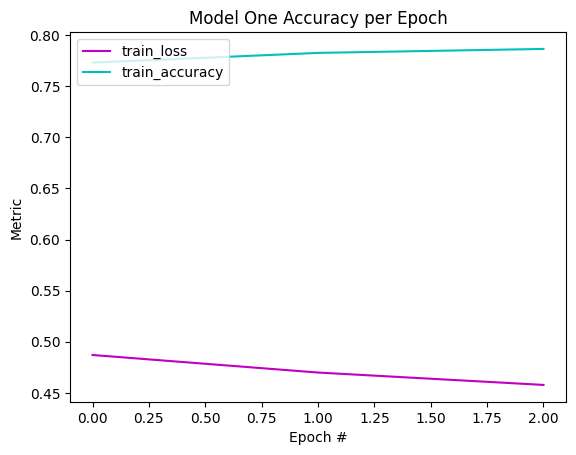

In [52]:
plt.plot(model_5.history['loss'],'m')
plt.plot(model_5.history['accuracy'],'c')
plt.title('Model One Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Metric')
plt.legend(['train_loss', 'train_accuracy'], loc='upper left')
plt.show()

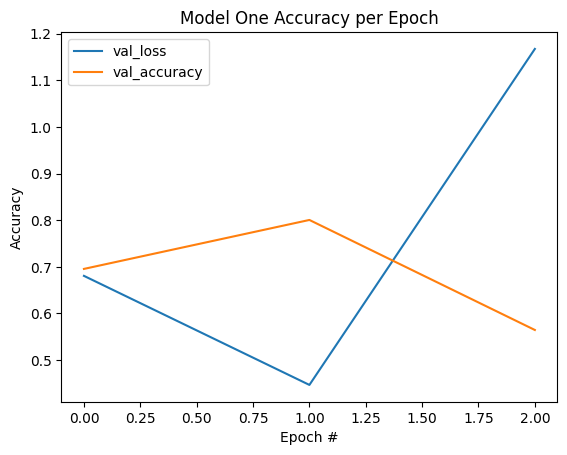

In [50]:
plt.plot(model_5.history['val_loss'])
plt.plot(model_5.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(['val_loss', 'val_accuracy'], loc='upper left')
plt.show()

In [51]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_6 = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=15,
                    callbacks=[reducel, earlystopper])

Epoch 1/15


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\831807310.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_6 = model.fit_generator(train_gen, steps_per_epoch=train_steps,


563/563 [==============================] - 114s 203ms/step - loss: 0.4395 - accuracy: 0.8005 - val_loss: 0.4360 - val_accuracy: 0.7895 - lr: 1.0000e-03
Epoch 2/15
563/563 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8067
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch: 1.
563/563 [==============================] - 113s 200ms/step - loss: 0.4257 - accuracy: 0.8067 - val_loss: 0.5063 - val_accuracy: 0.7585 - lr: 1.0000e-03
Epoch 2: early stopping


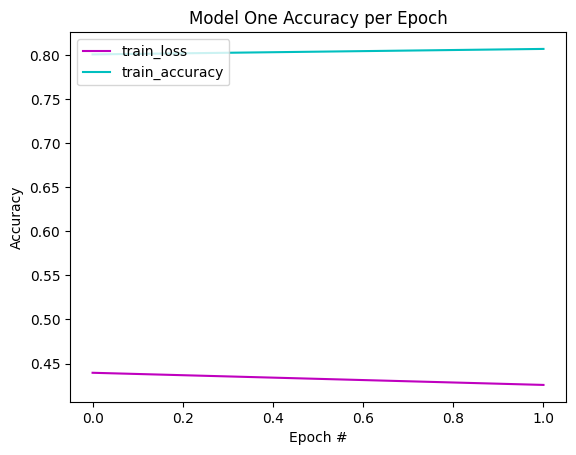

In [53]:
plt.plot(model_6.history['loss'],'m')
plt.plot(model_6.history['accuracy'],'c')
plt.title('Model One Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(['train_loss', 'train_accuracy'], loc='upper left')
plt.show()

# Simplest change:
Size of the batch changed. But no effects at all

The most straightforward change to be made was to increase the batch size before adding or removing parameters. The new batch size chosen was 64, since the original batch size was 32. 
The result was more or less the same. Any changes will involve other parameters.


In [54]:
from keras.preprocessing.image import ImageDataGenerator

imagesize = 96
train_samples_num = len(df_train)
val_samples_num = len(df_val)
train_batch_size = 64
val_batch_size = 64

train_steps = np.ceil(train_samples_num / train_batch_size)
val_steps = np.ceil(val_samples_num / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=val_batch_size,
                                        class_mode='binary')


test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [55]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.3
dropout_dense = 0.5

model3 = Sequential()
model3.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model3.add(Conv2D(first_filter, kernel_size, use_bias=False))
model3.add(Conv2D(first_filter, kernel_size, use_bias=False))
model3.add(MaxPool2D(pool_size = pool_size)) 
model3.add(Conv2D(first_filter, kernel_size, use_bias=False))
model3.add(MaxPool2D(pool_size = pool_size)) 
model3.add(Conv2D(first_filter, kernel_size, use_bias=False))
model3.add(MaxPool2D(pool_size = pool_size)) 
model3.add(MaxPool2D(pool_size = pool_size)) 

model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPool2D(pool_size = pool_size)) 
model3.add(Dropout(dropout_conv))

model3.add(Flatten())
model3.add(Dense(256, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Dropout(dropout_dense))
model3.add(Dense(1, activation = "sigmoid"))


model3.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model3.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_41 (Conv2D)          (None, 92, 92, 32)        9216      
                                                                 
 conv2d_42 (Conv2D)          (None, 90, 90, 32)        9216      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 43, 43, 32)        9216      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 21, 21, 32)        0         
 ng2D)                                                

In [56]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_4 = model3.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[reducel, earlystopper])

Epoch 1/5


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\2234244410.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_4 = model3.fit_generator(train_gen, steps_per_epoch=train_steps,


282/282 [==============================] - 104s 364ms/step - loss: 0.5402 - accuracy: 0.7436 - val_loss: 1.3442 - val_accuracy: 0.5230 - lr: 0.0100
Epoch 2/5
282/282 [==============================] - 104s 369ms/step - loss: 0.4633 - accuracy: 0.7853 - val_loss: 0.6427 - val_accuracy: 0.6415 - lr: 0.0100
Epoch 3/5
282/282 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.7953
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 2.
282/282 [==============================] - 113s 402ms/step - loss: 0.4417 - accuracy: 0.7953 - val_loss: 0.7874 - val_accuracy: 0.6015 - lr: 0.0100
Epoch 3: early stopping


## Batch Size returned to normal 
Conculsion for change in batch size:
Little to no effect.


In [59]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.3
dropout_dense = 0.5

model5 = Sequential()
model5.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model5.add(MaxPool2D(pool_size = pool_size)) 
model5.add(Conv2D(first_filter, kernel_size, use_bias=False))
model5.add(MaxPool2D(pool_size = pool_size)) 
model5.add(MaxPool2D(pool_size = pool_size)) 
model5.add(MaxPool2D(pool_size = pool_size)) 
model5.add(MaxPool2D(pool_size = pool_size)) 

model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(MaxPool2D(pool_size = pool_size)) 
model5.add(Dropout(dropout_conv))

model5.add(Flatten())
model5.add(Dense(256, use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(Dropout(dropout_dense))
model5.add(Dense(1, activation = "sigmoid"))


model5.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model5.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 45, 45, 32)        9216      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 11, 11, 32)        0         
 ng2D)                                                           
                                                      

In [60]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_6 = model5.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[reducel, earlystopper])

Epoch 1/5


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\2609964104.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_6 = model5.fit_generator(train_gen, steps_per_epoch=train_steps,


282/282 [==============================] - 31s 109ms/step - loss: 0.5442 - accuracy: 0.7371 - val_loss: 0.5206 - val_accuracy: 0.7330 - lr: 0.0100
Epoch 2/5
282/282 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7709
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 1.
282/282 [==============================] - 31s 110ms/step - loss: 0.4858 - accuracy: 0.7709 - val_loss: 0.5276 - val_accuracy: 0.7180 - lr: 0.0100
Epoch 2: early stopping


## Just some More experimentation

In [ ]:
plt.plot(model_5.history['accuracy'],'m')
plt.plot(model_5.history['val_accuracy'],'c')
plt.title('Model two Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(['train', 'validate'], loc='middle')
plt.show()

In [61]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.3
dropout_dense = 0.5

model6 = Sequential()
model6.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model6.add(MaxPool2D(pool_size = pool_size)) 
model6.add(Conv2D(first_filter, kernel_size, use_bias=False))
model6.add(MaxPool2D(pool_size = pool_size)) 
model6.add(Conv2D(first_filter, kernel_size, use_bias=False))
model6.add(MaxPool2D(pool_size = pool_size)) 
model6.add(Conv2D(first_filter, kernel_size, use_bias=False))
model6.add(MaxPool2D(pool_size = pool_size)) 
model6.add(MaxPool2D(pool_size = pool_size)) 

model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(MaxPool2D(pool_size = pool_size)) 
model6.add(Dropout(dropout_conv))

model6.add(Flatten())
model6.add(Dense(256, use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(Dropout(dropout_dense))
model6.add(Dense(1, activation = "sigmoid"))


model6.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model6.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 45, 45, 32)        9216      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 20, 20, 32)        9216      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 10, 10, 32)      

In [62]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_7 = model6.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[reducel, earlystopper])

Epoch 1/5


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\145434205.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_7 = model6.fit_generator(train_gen, steps_per_epoch=train_steps,


282/282 [==============================] - 34s 117ms/step - loss: 0.5523 - accuracy: 0.7396 - val_loss: 0.6524 - val_accuracy: 0.6230 - lr: 0.0100
Epoch 2/5
282/282 [==============================] - 32s 115ms/step - loss: 0.4804 - accuracy: 0.7802 - val_loss: 0.5609 - val_accuracy: 0.7155 - lr: 0.0100
Epoch 3/5
282/282 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.7967
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 2.
282/282 [==============================] - 32s 115ms/step - loss: 0.4583 - accuracy: 0.7967 - val_loss: 1.2950 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3: early stopping


In [ ]:
plt.plot(model_6.history['accuracy'],'m')
plt.plot(model_6.history['val_accuracy'],'c')
plt.title('Model two Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(['train', 'validate'], loc='middle')
plt.show()

In [63]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.1
dropout_dense = 0.5

model7 = Sequential()
model7.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(Conv2D(first_filter, kernel_size, use_bias=False))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(Conv2D(first_filter, kernel_size, use_bias=False))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(Conv2D(first_filter, kernel_size, use_bias=False))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(MaxPool2D(pool_size = pool_size)) 

model7.add(BatchNormalization())
model7.add(Activation("relu"))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(Dropout(dropout_conv))

model7.add(Conv2D(second_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(Conv2D(second_filter,, kernel_size, use_bias=False))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(Conv2D(second_filter,, kernel_size, use_bias=False))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(Conv2D(second_filter,, kernel_size, use_bias=False))
model7.add(MaxPool2D(pool_size = pool_size)) 
model7.add(MaxPool2D(pool_size = pool_size)) 


model7.add(Flatten())
model7.add(Dense(256, use_bias=False))
model7.add(BatchNormalization())
model7.add(Activation("relu"))
model7.add(Dropout(dropout_dense))
model7.add(Dense(1, activation = "sigmoid"))


model7.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model7.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 45, 45, 32)        9216      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 20, 20, 32)        9216      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 10, 10, 32)      

In [64]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_8 = model7.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[reducel, earlystopper])

Epoch 1/5


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\530079701.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_8 = model7.fit_generator(train_gen, steps_per_epoch=train_steps,


282/282 [==============================] - 33s 113ms/step - loss: 0.5358 - accuracy: 0.7506 - val_loss: 0.5021 - val_accuracy: 0.7575 - lr: 0.0100
Epoch 2/5
282/282 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7971
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 1.
282/282 [==============================] - 32s 114ms/step - loss: 0.4480 - accuracy: 0.7971 - val_loss: 0.5134 - val_accuracy: 0.7515 - lr: 0.0100
Epoch 2: early stopping


In [ ]:
plt.plot(model_7.history['accuracy'],'m')
plt.plot(model_7.history['val_accuracy'],'c')
plt.title('Model two Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(['train', 'validate'], loc='middle')
plt.show()

## Reduced Number of ConV2D
Max Reduced Number of Conv2D

Conversely, the applications of Conv2D will be reduced.

At first only 1 repetition will be used. There was a marketable decrease in accuracy. And the model discontinued after only 3 Epochs.


In [66]:
from keras.preprocessing.image import ImageDataGenerator

imagesize = 96
train_samples_num = len(df_train)
val_samples_num = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(train_samples_num / train_batch_size)
val_steps = np.ceil(val_samples_num / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=val_batch_size,
                                        class_mode='binary')


test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(imagesize,imagesize),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


CONV2D reduced Below

In [68]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.1
dropout_dense = 0.5

model8 = Sequential()
model8.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model8.add(MaxPool2D(pool_size = pool_size)) 

model8.add(BatchNormalization())
model8.add(Activation("relu"))
model8.add(MaxPool2D(pool_size = pool_size)) 
model8.add(Dropout(dropout_conv))





model8.add(Flatten())
model8.add(Dense(256, use_bias=False))
model8.add(BatchNormalization())
model8.add(Activation("relu"))
model8.add(Dropout(dropout_dense))
model8.add(Dense(1, activation = "sigmoid"))


model8.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model8.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_26 (Ba  (None, 47, 47, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_26 (Activation)  (None, 47, 47, 32)        0         
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                     

In [69]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_9 = model8.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[reducel, earlystopper])

Epoch 1/5


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\150718081.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_9 = model8.fit_generator(train_gen, steps_per_epoch=train_steps,


563/563 [==============================] - 52s 90ms/step - loss: 0.5249 - accuracy: 0.7535 - val_loss: 0.6027 - val_accuracy: 0.7015 - lr: 0.0100
Epoch 2/5
563/563 [==============================] - 51s 90ms/step - loss: 0.4479 - accuracy: 0.7932 - val_loss: 0.4068 - val_accuracy: 0.8130 - lr: 0.0100
Epoch 3/5
563/563 [==============================] - 52s 91ms/step - loss: 0.4223 - accuracy: 0.8112 - val_loss: 0.4032 - val_accuracy: 0.8190 - lr: 0.0100
Epoch 4/5
563/563 [==============================] - 50s 89ms/step - loss: 0.4085 - accuracy: 0.8160 - val_loss: 0.4012 - val_accuracy: 0.8260 - lr: 0.0100
Epoch 5/5
563/563 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8256
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 4.
563/563 [==============================] - 51s 90ms/step - loss: 0.3906 - accuracy: 0.8256 - val_loss: 0.4164 - val_accuracy: 0.8230 - lr: 0.0100
Epoch 5: e

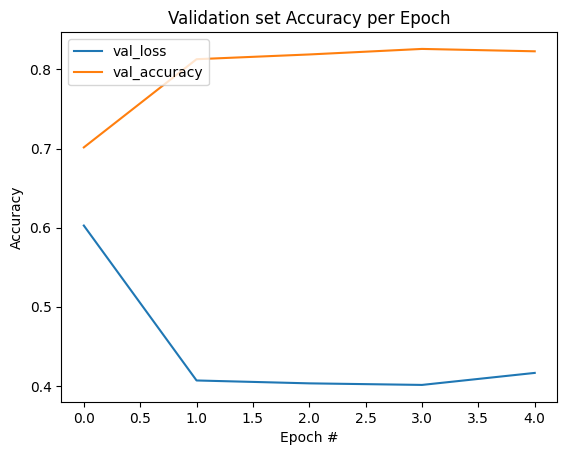

In [78]:
plt.plot(model_9.history['val_loss'])
plt.plot(model_9.history['val_accuracy'])
plt.title('Validation set Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(['val_loss', 'val_accuracy'], loc='upper left')
plt.show()

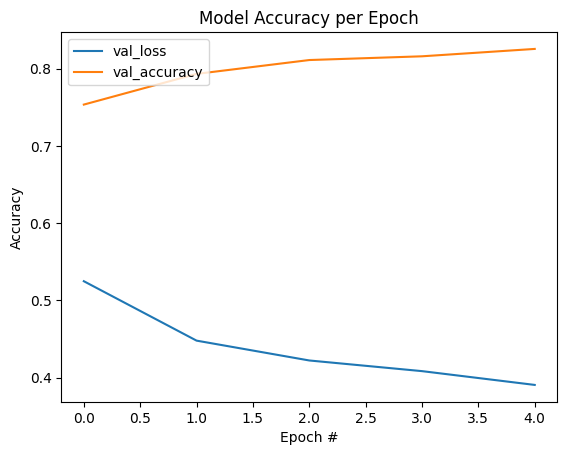

In [79]:
plt.plot(model_9.history['loss'])
plt.plot(model_9.history['accuracy'])
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(['val_loss', 'val_accuracy'], loc='upper left')
plt.show()

## Second Filter added
The first filter is already there.
I added to the filter for the COnv2D parameter and the model immediately was able to finish almost the entire 5 epochs of training. I filtered using the second filter as well as the first.Instead of just a single filter which the model originally contained.

In [81]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.1
dropout_dense = 0.5

model9 = Sequential()
model9.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model9.add(MaxPool2D(pool_size = pool_size)) 

model9.add(BatchNormalization())
model9.add(Activation("relu"))
model9.add(MaxPool2D(pool_size = pool_size)) 
model9.add(Dropout(dropout_conv))

model9.add(Conv2D(second_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))



model9.add(Flatten())
model9.add(Dense(256, use_bias=False))
model9.add(BatchNormalization())
model9.add(Activation("relu"))
model9.add(Dropout(dropout_dense))
model9.add(Dense(1, activation = "sigmoid"))


model9.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model9.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_28 (Ba  (None, 47, 47, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_28 (Activation)  (None, 47, 47, 32)        0         
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                     

In [82]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_10 = model9.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                   callbacks=[reducel, earlystopper])

Epoch 1/10


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\1895305655.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_10 = model9.fit_generator(train_gen, steps_per_epoch=train_steps,


563/563 [==============================] - 52s 91ms/step - loss: 0.5278 - accuracy: 0.7514 - val_loss: 2.1823 - val_accuracy: 0.5530 - lr: 0.0100
Epoch 2/10
563/563 [==============================] - 51s 91ms/step - loss: 0.4542 - accuracy: 0.7928 - val_loss: 0.9878 - val_accuracy: 0.5910 - lr: 0.0100
Epoch 3/10
563/563 [==============================] - 52s 92ms/step - loss: 0.4299 - accuracy: 0.8043 - val_loss: 0.4399 - val_accuracy: 0.8115 - lr: 0.0100
Epoch 4/10
563/563 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8177
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 3.
563/563 [==============================] - 52s 92ms/step - loss: 0.4099 - accuracy: 0.8177 - val_loss: 0.4428 - val_accuracy: 0.8315 - lr: 0.0100
Epoch 4: early stopping


## Maxpool added to second filter

In [83]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.1
dropout_dense = 0.5

model10 = Sequential()
model10.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model10.add(MaxPool2D(pool_size = pool_size)) 

model10.add(BatchNormalization())
model10.add(Activation("relu"))
model10.add(MaxPool2D(pool_size = pool_size)) 
model10.add(Dropout(dropout_conv))

model10.add(Conv2D(second_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model10.add(MaxPool2D(pool_size = pool_size)) 


model10.add(Flatten())
model10.add(Dense(256, use_bias=False))
model10.add(BatchNormalization())
model10.add(Activation("relu"))
model10.add(Dropout(dropout_dense))
model10.add(Dense(1, activation = "sigmoid"))


model10.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model10.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_30 (Ba  (None, 47, 47, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_30 (Activation)  (None, 47, 47, 32)        0         
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                     

In [84]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_11 = model10.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                   callbacks=[reducel, earlystopper])

Epoch 1/10


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\2062225469.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_11 = model10.fit_generator(train_gen, steps_per_epoch=train_steps,


563/563 [==============================] - 37s 63ms/step - loss: 0.5212 - accuracy: 0.7531 - val_loss: 0.4994 - val_accuracy: 0.7515 - lr: 0.0100
Epoch 2/10
563/563 [==============================] - 35s 62ms/step - loss: 0.4511 - accuracy: 0.7940 - val_loss: 0.4168 - val_accuracy: 0.8095 - lr: 0.0100
Epoch 3/10
563/563 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8076
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 2.
563/563 [==============================] - 36s 63ms/step - loss: 0.4249 - accuracy: 0.8076 - val_loss: 0.4664 - val_accuracy: 0.7735 - lr: 0.0100
Epoch 3: early stopping


## Batch Normalization

Each step has a normalization step added, immediate increase in accuracy and ability of model to train on additional epochs.

## Change batch normalization with Conv2D:

In [111]:

kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.3
dropout_dense = 0.5

model15 = Sequential()
model15.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model15.add(MaxPool2D(pool_size = pool_size)) 
model15.add(BatchNormalization())
model15.add(Activation("relu"))
model15.add(MaxPool2D(pool_size = pool_size))
model15.add(Dropout(dropout_conv))

model15.add(Conv2D(second_filter, kernel_size, use_bias=False))
model15.add(MaxPool2D(pool_size = pool_size))
model15.add(BatchNormalization())
model15.add(Activation("relu"))
model15.add(Dropout(dropout_conv))

model15.add(Conv2D(third_filter, kernel_size, use_bias=False))
model15.add(MaxPool2D(pool_size = pool_size))
model15.add(BatchNormalization())
model15.add(Activation("relu"))
model15.add(Dropout(dropout_conv))


model15.add(Flatten())
model15.add(Dense(256, use_bias=False))
model15.add(BatchNormalization())
model15.add(Activation("relu"))
model15.add(Dropout(dropout_dense))
model15.add(Dense(1, activation = "sigmoid"))


model15.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [112]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_16 = model15.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                   callbacks=[reducel, earlystopper])

Epoch 1/10


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\2675517937.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_16 = model15.fit_generator(train_gen, steps_per_epoch=train_steps,


1000/1000 [==============================] - 65s 64ms/step - loss: 0.4884 - accuracy: 0.7753 - val_loss: 0.4374 - val_accuracy: 0.8125 - lr: 0.0100
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8157
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1000/1000 [==============================] - 63s 63ms/step - loss: 0.4164 - accuracy: 0.8157 - val_loss: 0.6945 - val_accuracy: 0.7074 - lr: 0.0100
Epoch 3/10
1000/1000 [==============================] - 63s 63ms/step - loss: 0.3733 - accuracy: 0.8386 - val_loss: 0.3796 - val_accuracy: 0.8353 - lr: 1.0000e-03
Epoch 4/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3586 - accuracy: 0.8453 - val_loss: 0.3480 - val_accuracy: 0.8514 - lr: 1.0000e-03
Epoch 5/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8482
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1000/1000 [===================

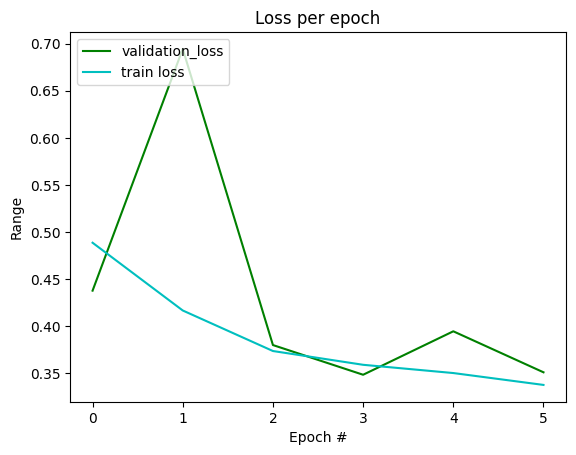

In [125]:
plt.plot(model_16.history['val_loss'],'g')
plt.plot(model_16.history['loss'],'c')
plt.title('Loss per epoch')
plt.xlabel('Epoch #')
plt.ylabel('Range')
plt.legend(['validation_loss', 'train loss'], loc='upper left')
plt.show()

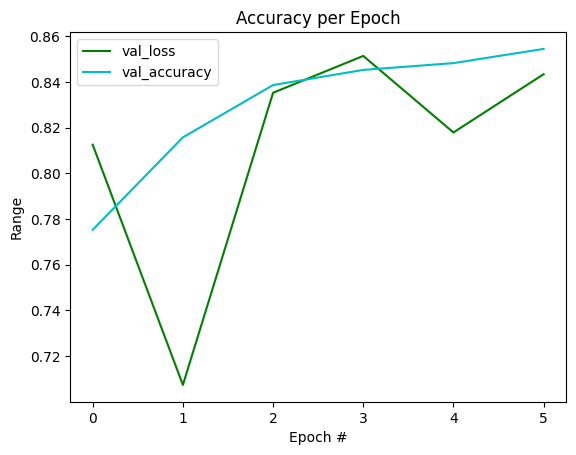

In [126]:
plt.plot(model_16.history['val_accuracy'],'g')
plt.plot(model_16.history['accuracy'],'c')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Range')
plt.legend(['val_loss', 'val_accuracy'], loc='upper left')
plt.show()

## Changed Dropout CONV

Each unique filter had Cov2D applied only once, and normalization after pooling.

A marketable increase indeed. Now it seems the model simply needs some fine tuning and it should function pretty well. The loss scores and accuracy increased for both the validation and training set. 

In [113]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.1 # Changed this value
dropout_dense = 0.5

model16 = Sequential()
model16.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model16.add(MaxPool2D(pool_size = pool_size)) 
model16.add(BatchNormalization())
model16.add(Activation("relu"))
model16.add(MaxPool2D(pool_size = pool_size))
model16.add(Dropout(dropout_conv))

model16.add(Conv2D(second_filter, kernel_size, use_bias=False))
model16.add(MaxPool2D(pool_size = pool_size))
model16.add(BatchNormalization())
model16.add(Activation("relu"))
model16.add(Dropout(dropout_conv))

model16.add(Conv2D(third_filter, kernel_size, use_bias=False))
model16.add(MaxPool2D(pool_size = pool_size))
model16.add(BatchNormalization())
model16.add(Activation("relu"))
model16.add(Dropout(dropout_conv))


model16.add(Flatten())
model16.add(Dense(256, use_bias=False))
model16.add(BatchNormalization())
model16.add(Activation("relu"))
model16.add(Dropout(dropout_dense))
model16.add(Dense(1, activation = "sigmoid"))

model16.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [114]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
model_17 = model16.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                   callbacks=[reducel, earlystopper])

Epoch 1/10


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\289038352.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_17 = model16.fit_generator(train_gen, steps_per_epoch=train_steps,


1000/1000 [==============================] - 64s 63ms/step - loss: 0.4681 - accuracy: 0.7870 - val_loss: 0.5407 - val_accuracy: 0.7334 - lr: 0.0100
Epoch 2/10
1000/1000 [==============================] - 63s 63ms/step - loss: 0.4011 - accuracy: 0.8209 - val_loss: 0.3910 - val_accuracy: 0.8288 - lr: 0.0100
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8311
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3867 - accuracy: 0.8311 - val_loss: 0.4238 - val_accuracy: 0.7985 - lr: 0.0100
Epoch 4/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3445 - accuracy: 0.8515 - val_loss: 0.3199 - val_accuracy: 0.8620 - lr: 1.0000e-03
Epoch 5/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3304 - accuracy: 0.8584 - val_loss: 0.3117 - val_accuracy: 0.8680 - lr: 1.0000e-03
Epoch 6/10
1000/1000 [=======================

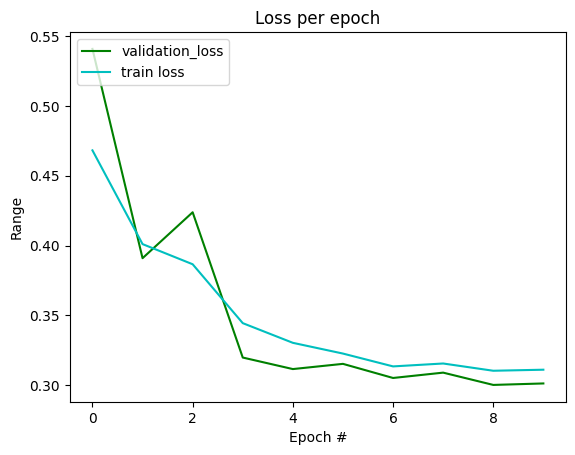

In [123]:
plt.plot(model_17.history['val_loss'],'g')
plt.plot(model_17.history['loss'],'c')
plt.title('Loss per epoch')
plt.xlabel('Epoch #')
plt.ylabel('Range')
plt.legend(['validation_loss', 'train loss'], loc='upper left')
plt.show()

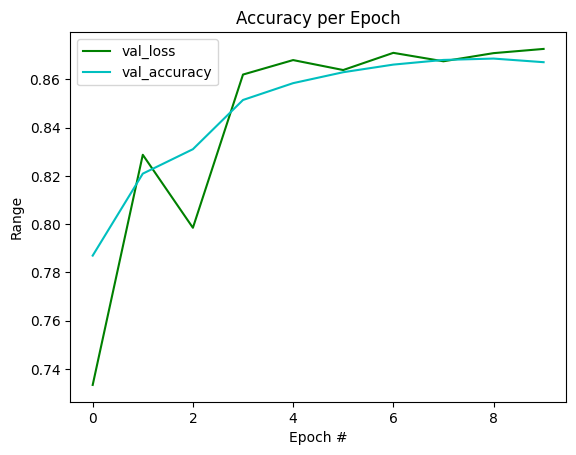

In [124]:
plt.plot(model_17.history['val_accuracy'],'g')
plt.plot(model_17.history['accuracy'],'c')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch #')
plt.ylabel('Range')
plt.legend(['val_loss', 'val_accuracy'], loc='upper left')
plt.show()

## Patience increased

In [115]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.1
dropout_dense = 0.5

model17 = Sequential()
model17.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model17.add(MaxPool2D(pool_size = pool_size)) 
model17.add(BatchNormalization())
model17.add(Activation("relu"))
model17.add(MaxPool2D(pool_size = pool_size))
model17.add(Dropout(dropout_conv))

model17.add(Conv2D(second_filter, kernel_size, use_bias=False))
model17.add(MaxPool2D(pool_size = pool_size))
model17.add(BatchNormalization())
model17.add(Activation("relu"))
model17.add(Dropout(dropout_conv))

model17.add(Conv2D(third_filter, kernel_size, use_bias=False))
model17.add(MaxPool2D(pool_size = pool_size))
model17.add(BatchNormalization())
model17.add(Activation("relu"))
model17.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model17.add(Flatten())
model17.add(Dense(256, use_bias=False))
model17.add(BatchNormalization())
model17.add(Activation("relu"))
model17.add(Dropout(dropout_dense))
model17.add(Dense(1, activation = "sigmoid"))

# Compile the model
model17.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [116]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1)
model_18 = model17.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                   callbacks=[reducel, earlystopper])

Epoch 1/10


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\2051343527.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_18 = model17.fit_generator(train_gen, steps_per_epoch=train_steps,


1000/1000 [==============================] - 65s 64ms/step - loss: 0.4734 - accuracy: 0.7857 - val_loss: 0.5408 - val_accuracy: 0.7782 - lr: 0.0100
Epoch 2/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3990 - accuracy: 0.8212 - val_loss: 1.0758 - val_accuracy: 0.6326 - lr: 0.0100
Epoch 3/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3823 - accuracy: 0.8330 - val_loss: 0.4927 - val_accuracy: 0.7837 - lr: 0.0100
Epoch 4/10
1000/1000 [==============================] - 63s 63ms/step - loss: 0.3675 - accuracy: 0.8430 - val_loss: 0.3766 - val_accuracy: 0.8278 - lr: 0.0100
Epoch 5/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3575 - accuracy: 0.8483 - val_loss: 0.3986 - val_accuracy: 0.8253 - lr: 0.0100
Epoch 6/10
1000/1000 [==============================] - 63s 63ms/step - loss: 0.3376 - accuracy: 0.8572 - val_loss: 0.3235 - val_accuracy: 0.8566 - lr: 0.0100
Epoch 7/10
1000/1000 [==============================] - 6

In [129]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.1
dropout_dense = 0.5

model19 = Sequential()
model19.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model19.add(MaxPool2D(pool_size = pool_size)) 
model19.add(BatchNormalization())
model19.add(Activation("relu"))
model19.add(MaxPool2D(pool_size = pool_size))
model19.add(Dropout(dropout_conv))

model19.add(Conv2D(second_filter, kernel_size, use_bias=False))
model19.add(MaxPool2D(pool_size = pool_size))
model19.add(BatchNormalization())
model19.add(Activation("relu"))
model19.add(Dropout(dropout_conv))

model19.add(Conv2D(third_filter, kernel_size, use_bias=False))
model19.add(MaxPool2D(pool_size = pool_size))
model19.add(BatchNormalization())
model19.add(Activation("relu"))
model19.add(Dropout(dropout_conv))

model19.add(Flatten())
model19.add(Dense(256, use_bias=False))
model19.add(BatchNormalization())
model19.add(Activation("relu"))
model19.add(Dropout(dropout_dense))
model19.add(Dense(1, activation = "sigmoid"))


model19.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1)
model_20 = model19.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20,
                   callbacks=[reducel, earlystopper])

## Small modifications for better predictions on test data

In [264]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.2
dropout_dense = 0.5

model20 = Sequential()
model20.add(Conv2D(first_filter, kernel_size, activation = 'relu', input_shape = (imagesize, imagesize, 3)))
model20.add(MaxPool2D(pool_size = pool_size)) 
model20.add(BatchNormalization())
model20.add(Activation("relu"))
model20.add(MaxPool2D(pool_size = pool_size))
model20.add(Dropout(dropout_conv))

model20.add(Conv2D(second_filter, kernel_size, use_bias=False))
model20.add(MaxPool2D(pool_size = pool_size))
model20.add(BatchNormalization())
model20.add(Activation("relu"))
model20.add(Dropout(dropout_conv))

model20.add(Conv2D(third_filter, kernel_size, use_bias=False))
model20.add(MaxPool2D(pool_size = pool_size))
model20.add(BatchNormalization())
model20.add(Activation("relu"))
model20.add(Dropout(dropout_conv))

model20.add(Flatten())
model20.add(Dense(256, use_bias=False))
model20.add(BatchNormalization())
model20.add(Activation("relu"))
model20.add(Dropout(dropout_dense))
model20.add(Dense(1, activation = "sigmoid"))


model20.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [265]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1)
model_21 = model20.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=11,
                   callbacks=[reducel, earlystopper])

Epoch 1/11


C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\2141937084.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_21 = model20.fit_generator(train_gen, steps_per_epoch=train_steps,


1000/1000 [==============================] - 173s 172ms/step - loss: 0.4781 - accuracy: 0.7834 - val_loss: 0.4229 - val_accuracy: 0.8160 - lr: 0.0100
Epoch 2/11
1000/1000 [==============================] - 83s 83ms/step - loss: 0.4084 - accuracy: 0.8183 - val_loss: 0.4195 - val_accuracy: 0.8123 - lr: 0.0100
Epoch 3/11
1000/1000 [==============================] - 95s 95ms/step - loss: 0.3886 - accuracy: 0.8300 - val_loss: 0.4068 - val_accuracy: 0.8158 - lr: 0.0100
Epoch 4/11
1000/1000 [==============================] - 82s 82ms/step - loss: 0.3665 - accuracy: 0.8429 - val_loss: 0.3233 - val_accuracy: 0.8599 - lr: 0.0100
Epoch 5/11
1000/1000 [==============================] - 97s 97ms/step - loss: 0.3616 - accuracy: 0.8438 - val_loss: 0.3625 - val_accuracy: 0.8478 - lr: 0.0100
Epoch 6/11
1000/1000 [==============================] - 84s 84ms/step - loss: 0.3484 - accuracy: 0.8526 - val_loss: 0.2912 - val_accuracy: 0.8751 - lr: 0.0100
Epoch 7/11
1000/1000 [==============================] -

Model finally seems acceptable. 
Performing pretty decently. 

Plots of all of my resulting accuracy scores.

In [266]:
max5 = max(model_5.history['accuracy'])
max6 = max(model_6.history['accuracy'])
max7 = max(model_7.history['accuracy'])
max8 = max(model_8.history['accuracy'])
max9 = max(model_9.history['accuracy'])
max10 = max(model_10.history['accuracy'])
max11 = max(model_11.history['accuracy'])
max14 = max(model_14.history['accuracy'])
max15 = max(model_15.history['accuracy'])
max16 = max(model_16.history['accuracy'])
max17 = max(model_17.history['accuracy'])
max18 = max(model_18.history['accuracy'])
max19 = max(model_19.history['accuracy'])
max20 = max(model_20.history['accuracy'])
max21 = (model_20.history['accuracy'])

In [187]:
maxess = [max5,max6,max7,max8,max9,max10,max11,max14,max15,max16,max17,max18,max19,max20]

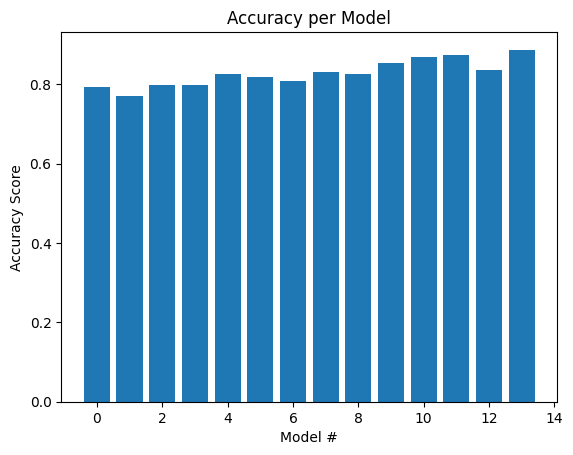

In [195]:
plt.bar(range(len(maxess)),maxess)
plt.title('Accuracy per Model')
plt.xlabel('Model #')
plt.ylabel('Accuracy Score')
plt.show()

In [198]:
max5 = max(model_5.history['loss'])
max6 = max(model_6.history['loss'])
max7 = max(model_7.history['loss'])
max8 = max(model_8.history['loss'])
max9 = max(model_9.history['loss'])
max10 = max(model_10.history['loss'])
max11 = max(model_11.history['loss'])
max14 = max(model_14.history['loss'])
max15 = max(model_15.history['loss'])
max16 = max(model_16.history['loss'])
max17 = max(model_17.history['loss'])
max18 = max(model_18.history['loss'])
max19 = max(model_19.history['loss'])
max20 = max(model_20.history['loss'])
maxess = [max5,max6,max7,max8,max9,max10,max11,max14,max15,max16,max17,max18,max19,max20]

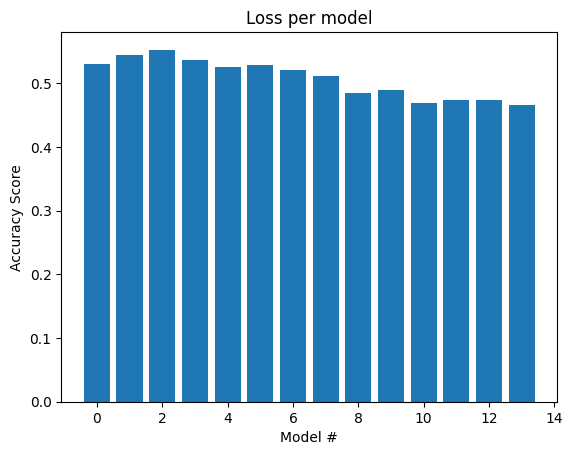

In [199]:
plt.bar(range(len(maxess)),maxess)
plt.title('Loss per model')
plt.xlabel('Model #')
plt.ylabel('Accuracy Score')
plt.show()

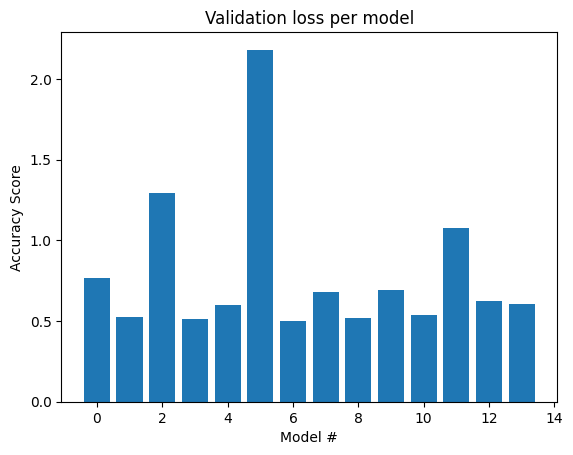

In [206]:
max5 = max(model_5.history['val_loss'])
max6 = max(model_6.history['val_loss'])
max7 = max(model_7.history['val_loss'])
max8 = max(model_8.history['val_loss'])
max9 = max(model_9.history['val_loss'])
max10 = max(model_10.history['val_loss'])
max11 = max(model_11.history['val_loss'])
max14 = max(model_14.history['val_loss'])
max15 = max(model_15.history['val_loss'])
max16 = max(model_16.history['val_loss'])
max17 = max(model_17.history['val_loss'])
max18 = max(model_18.history['val_loss'])
max19 = max(model_19.history['val_loss'])
max20 = max(model_20.history['val_loss'])
maxess = [max5,max6,max7,max8,max9,max10,max11,max14,max15,max16,max17,max18,max19,max20]
plt.bar(range(len(maxess)),maxess)
plt.title('Validation loss per model')
plt.xlabel('Model #')
plt.ylabel('Accuracy Score')
plt.show()

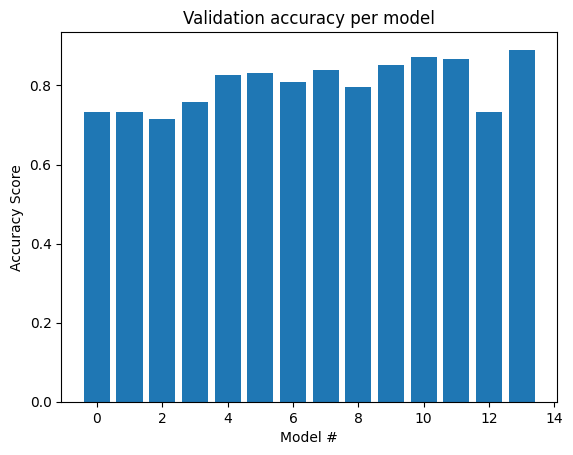

In [207]:
max5 = max(model_5.history['val_accuracy'])
max6 = max(model_6.history['val_accuracy'])
max7 = max(model_7.history['val_accuracy'])
max8 = max(model_8.history['val_accuracy'])
max9 = max(model_9.history['val_accuracy'])
max10 = max(model_10.history['val_accuracy'])
max11 = max(model_11.history['val_accuracy'])
max14 = max(model_14.history['val_accuracy'])
max15 = max(model_15.history['val_accuracy'])
max16 = max(model_16.history['val_accuracy'])
max17 = max(model_17.history['val_accuracy'])
max18 = max(model_18.history['val_accuracy'])
max19 = max(model_19.history['val_accuracy'])
max20 = max(model_20.history['val_accuracy'])
maxess = [max5,max6,max7,max8,max9,max10,max11,max14,max15,max16,max17,max18,max19,max20]
plt.bar(range(len(maxess)),maxess)
plt.title('Validation accuracy per model')
plt.xlabel('Model #')
plt.ylabel('Accuracy Score')
plt.show()

Text(0.5, 0, 'Epoch')

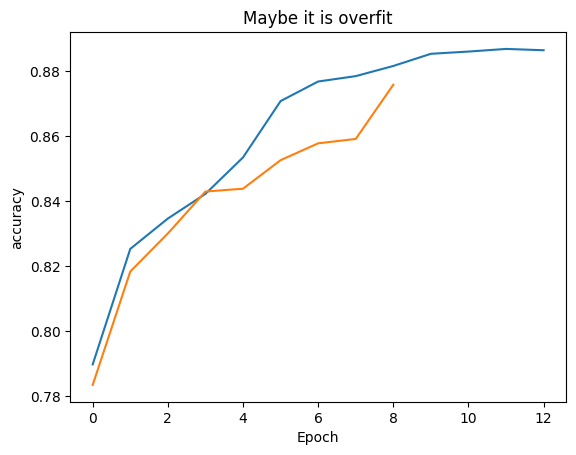

In [271]:
plt.plot(model_20.history['accuracy'])
plt.plot(model_21.history['accuracy'])
plt.title("Maybe it is overfit")
plt.ylabel("accuracy")
plt.xlabel("Epoch")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


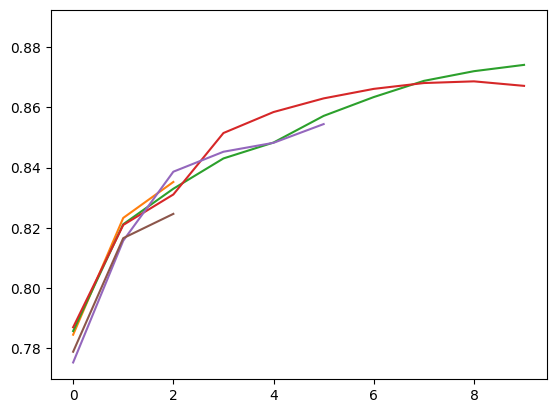

In [160]:
print(model_20.history.keys())
plt.plot(max(model_20.history['accuracy']))
plt.plot(model_19.history['accuracy'])
plt.plot(model_18.history['accuracy'])
plt.plot(model_17.history['accuracy'])
plt.plot(model_16.history['accuracy'])
plt.plot(model_15.history['accuracy'])
max20 = (model_20.history['accuracy'])

In [155]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_pred = model19.predict_generator(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

  43/8000 [..............................] - ETA: 19s

C:\Users\amcfa\AppData\Local\Temp\ipykernel_17948\3316063053.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model19.predict_generator(test_gen, steps=len(df_val), verbose=1)


8000/8000 [==============================] - 18s 2ms/step


0.95967575

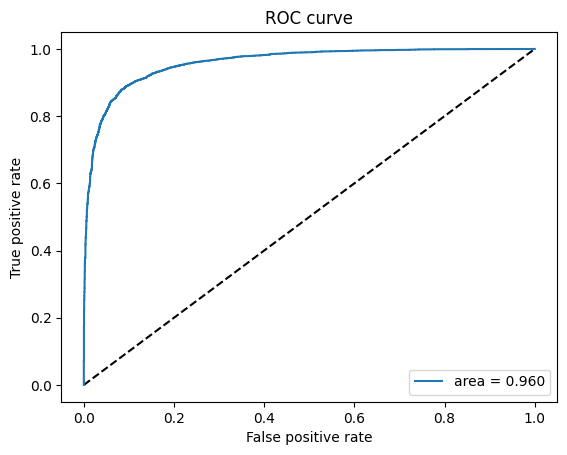

In [147]:
## ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [151]:
from skimage.io import imread
# Load test data and make a prediction

In [273]:
import cv2 as cv
base_test_dir = '../input/test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('\\')[1].split(".")[0]) 
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model20.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

Indexes: 0 - 5000
157/157 [==============================] - 2s 15ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 2s 14ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 2s 15ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 2s 15ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 2s 15ms/step
Indexes: 25000 - 30000
157/157 [==============================] - 2s 14ms/step
Indexes: 30000 - 35000
157/157 [==============================] - 2s 15ms/step
Indexes: 35000 - 40000
157/157 [==============================] - 2s 15ms/step
Indexes: 40000 - 45000
157/157 [==============================] - 3s 16ms/step
Indexes: 45000 - 50000
157/157 [==============================] - 3s 16ms/step
Indexes: 50000 - 55000
157/157 [==============================] - 3s 17ms/step
Indexes: 55000 - 60000
77/77 [==============================] - 1s 16ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.873092
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.774387
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.802865
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.001870
4,000270442cc15af719583a8172c87cd2bd9c7746,0.011828


In [274]:
shutil.rmtree(train_path)
shutil.rmtree(valid_path)
submission.to_csv("submission.csv", index = False, header = True)

In [ ]:
history[0]